##### Copyright 2018 Google LLC.

Licensed under the Apache License, Version 2.0 (the "License");

In [0]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Background experiments for Generation of Semi-Transparent Patterns

This notebook uses  [**Lucid**](https://github.com/tensorflow/lucid) to produce semi-transparent feature visualizations that are similar in spirit to the feature visualizations in [Differentiable Image Parameterizations](https://distill.pub/2018/differentiable-parameterizations/#section-rgba). 

Here, we experimented with different backgrounds, and found no particularly interesting dependency: as long as the background was random, the resulting visualizations created the kind of alpha masks we expected. **In a sense, this is a null result, and we provide the code primarily for interested tinkerers.**

This notebook doesn't introduce the abstractions behind lucid; you may wish to also read the [Lucid tutorial](https://colab.research.google.com/github/tensorflow/lucid/blob/master/notebooks/tutorial.ipynb).

**Note**: The easiest way to use this tutorial is as a colab notebook, which allows you to dive in with no setup. We recommend you enable a free GPU by going:

> **Runtime**   →   **Change runtime type**   →   **Hardware Accelerator: GPU**

## Install, Import, Load Model

In [0]:
# Install Lucid & tensorflow
# %tenorflow_version only works on colab
%tenorflow_version 1.x

!pip install --quiet lucid

In [0]:
# Imports

import numpy as np
import tensorflow as tf
assert tf.__version__.startswith('1')

import lucid.modelzoo.vision_models as models
from lucid.misc.io import show
import lucid.optvis.objectives as objectives
import lucid.optvis.param as param
import lucid.optvis.render as render
import lucid.optvis.transform as transform

In [0]:
# Let's import a model from the Lucid modelzoo!

model = models.InceptionV1()
model.load_graphdef()

# Preparation

Lucid's `lucid.optvis.param`(*eterizations*) provides `image_sample` to get a random background:


Decorrelate: False
Decay power: 1



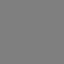
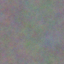
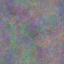
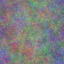
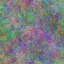
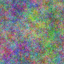
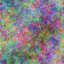
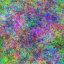
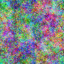
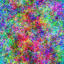

Decay power: 1.5



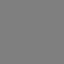
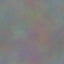
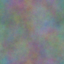
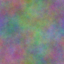
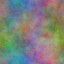
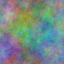
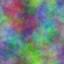
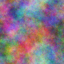
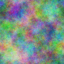
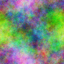

Decay power: 2



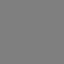
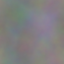
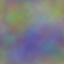
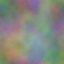
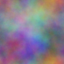
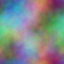
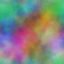
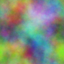
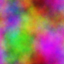
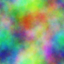


Decorrelate: True
Decay power: 1



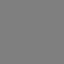
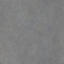
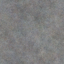
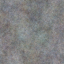
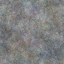
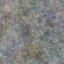
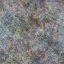
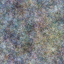
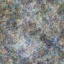
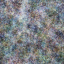

Decay power: 1.5



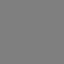
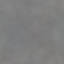
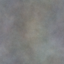
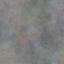
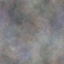
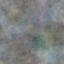
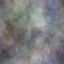
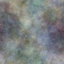
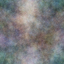
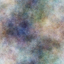

Decay power: 2



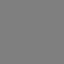
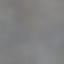
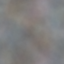
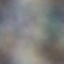
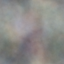
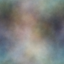
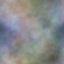
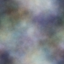
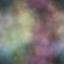
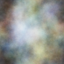

In [10]:
with tf.Graph().as_default(), tf.Session():
  
  for decorrelate in [False, True]:
    print("\nDecorrelate: {}".format(decorrelate))
    
    for decay_power in [1, 1.5, 2]:
      print("Decay power: {}".format(decay_power))
      decay_power_reg = 20**(-decay_power + 1)
      images = [param.image_sample([1, 64, 64, 3], sd=decay_power_reg*n/20., decay_power=decay_power, decorrelate=decorrelate).eval() for n in range(10)]
      show(images)

# Experiment 1

Here we try out our alpha parameterization on different backgrounds. Some are merely random, but drawn from different distributions, while others are optimized—either supporting the objective or opposing it. A weak hypothesis we held when starting out was that an adversarial background would really help narrow down which parts of the foreground needed to be opague. While this does seem to work, in expectation it doesn't seem to work better than a random background—in fact it appears that an adversarial background may force the foreground to "defend" itself by making areas near the object opaque.

## Setup

In [0]:
def make_bg_func(noise_ratio=0.5, decay_power=1.5, base_sd=0.8,
                 decorrelate=True, var_mode="image", var_image_jitter=0):
  def bg_func(w):
    if var_mode =="image":
      var_img = param.image(w+var_image_jitter, decorrelate=decorrelate)
      var_img = transform.jitter(var_image_jitter)(var_img)
    elif var_mode =="color":
      var_img = param.image(5, decorrelate=decorrelate)[:, 3:4, 3:4, :]
    noise = param.image_sample([1, w, w, 3], sd=base_sd*20**(-decay_power + 1), decay_power=decay_power, decorrelate=decorrelate)
    return (1-noise_ratio)*var_img + noise_ratio*noise
  return bg_func



In [0]:
def alpha_experiment(layer, neuron, bg_func, alpha_loss_coef=1e4, jitter_n=2, w=128, bg_adv=True, transforms=None):

  with tf.Graph().as_default(), tf.Session():

    t_img = param.image(w, alpha=True)
    t_bg = bg_func(w)
    
    # Compose bg and image -- this includes
    # * jittering rgb, alpha, and background relative to each other
    # * Blocking gradients so that we can optimize foreground/background separately
    t_rgb, t_alpha = t_img[..., :3], t_img[..., 3:4]
    jitter = transform.jitter(jitter_n)
    t_rgb_, t_alpha_, t_bg_ = jitter(t_rgb), jitter(t_alpha), jitter(t_bg)
    t_flat  = t_rgb_*t_alpha_ + (1-t_alpha_)*tf.stop_gradient(t_bg_)
    t_flat_ = tf.stop_gradient(t_rgb_*t_alpha_) + tf.stop_gradient(1-t_alpha_)*t_bg_
    t_inp = tf.concat([t_flat, t_flat_], axis=0)

    # Create the objective
    t_alpha_mean = tf.reduce_mean(t_alpha)
    obj  = objectives.channel(layer, neuron, batch=0)
    if bg_adv:
      obj -= objectives.channel(layer, neuron, batch=1)
      #obj -= objectives.neuron(layer, neuron, batch=1)
    else:
      obj += objectives.channel(layer, neuron, batch=1)
    obj += alpha_loss_coef*objectives.Objective(lambda T: -tf.square(t_alpha_mean-0.25) )

    # Optimize the visualization
    T = render.make_vis_T(model, obj, t_inp, transforms=transforms)
    tf.global_variables_initializer().run()
    for i in range(512):
      #if i%16 == 0: print ".",
      T("vis_op").run()

    # Show the visualization
    img = t_img.eval()
    rgb, alpha = img[..., :3], img[..., 3:4]
    #show([img, rgb*alpha + (1-alpha)*(0.5+0.5*rgb), rgb, 1-alpha,  t_bg.eval(), t_flat.eval()])
    show(np.hstack([(rgb*alpha + 1-alpha)[0], t_bg.eval()[0]]))

Let's make sure these two work together:


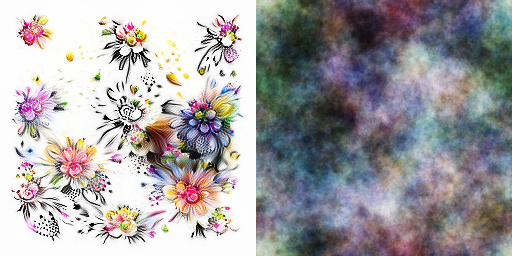

In [0]:
  alpha_experiment("mixed4d_3x3_bottleneck_pre_relu", 139,
    bg_func=make_bg_func(noise_ratio=1.0, decay_power=1.5, base_sd=0.4, decorrelate=True),
    alpha_loss_coef=1e4,
    jitter_n=1,
    bg_adv=False,
    w=256,
    transforms=[transform.jitter(8), transform.jitter(8), transform.jitter(8), transform.random_scale([0.95, 0.98, 1.0, 1.02, 1.05]), transform.jitter(8)]
  )

## Test

A small helper to run a list of different backgrounds on a single neuron :

In [0]:
def test(layer, neuron, alpha_loss_coef=1e4, jitter_n=2):
  
  print "Adverserial Background Image Full"
  alpha_experiment(layer, neuron,
    bg_func=make_bg_func(noise_ratio=0.0, decay_power=1.5, base_sd=0.3, decorrelate=True, var_mode="image", var_image_jitter=0),
    alpha_loss_coef=alpha_loss_coef,
    jitter_n=jitter_n,
    bg_adv=True
  )
  

  print ""
  print "Adverserial Background Image Random Offset"
  alpha_experiment(layer, neuron,
    bg_func=make_bg_func(noise_ratio=0.0, decay_power=1.5, base_sd=0.3, decorrelate=True, var_mode="image", var_image_jitter=128),
    alpha_loss_coef=alpha_loss_coef,
    jitter_n=jitter_n,
    bg_adv=True
  )
  

  print ""
  print "Adverserial Background Color"
  alpha_experiment(layer, neuron,
    bg_func=make_bg_func(noise_ratio=0.0, decay_power=1.5, base_sd=0.3, decorrelate=True, var_mode="color"),
    alpha_loss_coef=alpha_loss_coef,
    jitter_n=jitter_n,
    bg_adv=True
  )
  

  print ""
  print "Noise Background"
  alpha_experiment(layer, neuron,
    bg_func=make_bg_func(noise_ratio=1.0, decay_power=2, base_sd=0.1, decorrelate=True, var_mode="color"),
    alpha_loss_coef=alpha_loss_coef,
    jitter_n=jitter_n,
    bg_adv=True
  )
  

  print ""
  print "Allied Background Color"
  alpha_experiment(layer, neuron,
    bg_func=make_bg_func(noise_ratio=0.0, decay_power=1.5, base_sd=0.3, decorrelate=True, var_mode="color"),
    alpha_loss_coef=alpha_loss_coef,
    jitter_n=jitter_n,
    bg_adv=False
  )
  

  print ""
  print "Allied Background Image Random Offset"
  alpha_experiment(layer, neuron,
    bg_func=make_bg_func(noise_ratio=0.0, decay_power=1.5, base_sd=0.3, decorrelate=True, var_mode="image", var_image_jitter=128),
    alpha_loss_coef=alpha_loss_coef,
    jitter_n=jitter_n,
    bg_adv=False
  )
  
  print ""
  print "Allied Background Image Full"
  alpha_experiment(layer, neuron,
    bg_func=make_bg_func(noise_ratio=0.0, decay_power=1.5, base_sd=0.3, decorrelate=True, var_mode="image", var_image_jitter=0),
    alpha_loss_coef=alpha_loss_coef,
    jitter_n=jitter_n,
    bg_adv=False
  )
  
  
  
  
  

Let's see this on three different neurons:

Adverserial Background Image Full



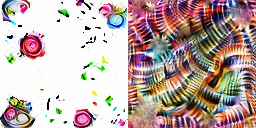


Adverserial Background Image Random Offset



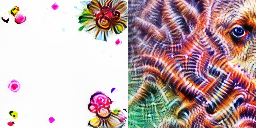


Adverserial Background Color



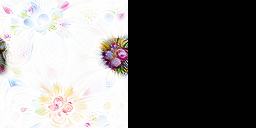


Noise Background



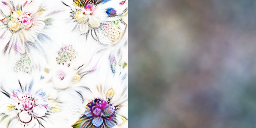


Allied Background Color



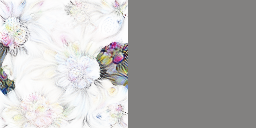


Allied Background Image Random Offset



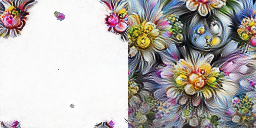


Allied Background Image Full



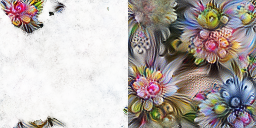

In [0]:
test("mixed4d_3x3_bottleneck_pre_relu", 139)

Adverserial Background Image Full



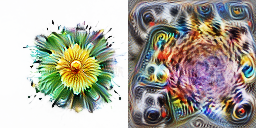


Adverserial Background Image Random Offset



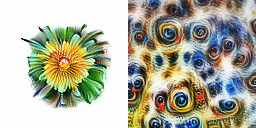


Adverserial Background Color



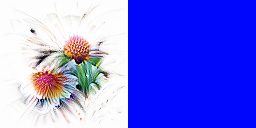


Noise Background



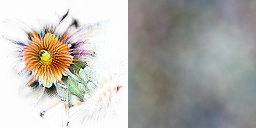


Allied Background Color



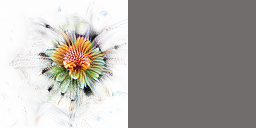


Allied Background Image Random Offset



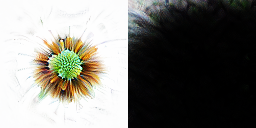


Allied Background Image Full



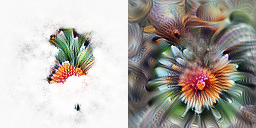

In [0]:
test("mixed4b_pool_reduce_pre_relu", 16)

Adverserial Background Image Full



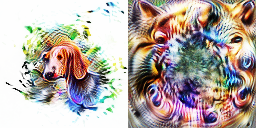


Adverserial Background Image Random Offset



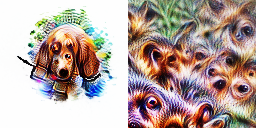


Adverserial Background Color



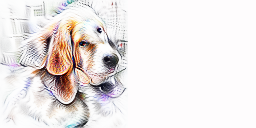


Noise Background



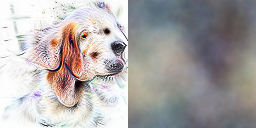


Allied Background Color



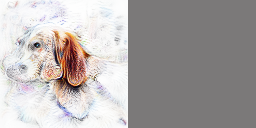


Allied Background Image Random Offset



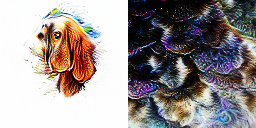


Allied Background Image Full



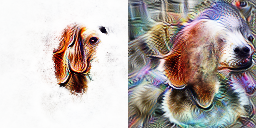

In [0]:
test("mixed4d_pre_relu", 426,)

# Experiment 2

One factor that made comparing the different backgrounds hard in experiment 1 is the same problem that "Aligned Feature Vis interpolation" addresses—visual landmarks, such as ears, are not in the same position between those visualizations.

Experiment 2 tried to address this by introducing a shared paremeterization for the image foregrounds.

We didn't experiment with this very much, and it apperas that in our initial attempts the shared parameterization may have been too strong, causing the different visualizations to be essentially identical, instead of just aligned. **If one wanted to explore this direction further, that would be something to fiddle with.**

## Setup

In [0]:
def alpha_experiment_2(layer, neuron, bg_list_func, bgs_adv=True, w=128, jitter_n=2, shared_param_coef=0.5):
  with tf.Graph().as_default(), tf.Session():
    
    bgs = bg_list_func(w)
    N = len(bgs)
    
    make_param = lambda: sum(param.lowres_tensor([w, w, 4], [w//k, w//k, 4]) for k in [1,2,4,8])/4.0 # <-- shared param is here
    shared_param  = make_param()
    fgs = []
    for _ in range(N):
      fg_param = shared_param_coef*shared_param + make_param()
      rgb = param.to_valid_rgb(fg_param[..., :3], decorrelate=True)
      alpha = tf.nn.sigmoid(fg_param[..., 3:4])
      fgs.append(tf.concat([rgb, alpha], axis=-1))
    
    if isinstance(bgs_adv, bool):
      bgs_adv = N*[bgs_adv]
    
    flats = []
    obj = 0
    for n, (fg, bg, adv) in enumerate(zip(fgs, bgs, bgs_adv)):
      rgb, alpha = fg[..., :3], fg[..., 3:4]
      jitter = transform.jitter(jitter_n)
      rgb, alpha, bg = jitter(rgb), jitter(alpha), jitter(bg)
      flats.append(rgb*alpha + (1-alpha)*tf.stop_gradient(bg))
      flats.append(tf.stop_gradient(rgb*alpha) + tf.stop_gradient(1-alpha)*bg)
      obj += objectives.neuron(layer, neuron, batch=2*n)
      adv_sign = -1 if adv else 1
      obj += adv_sign * (objectives.neuron(layer, neuron, batch=2*n+1) +  objectives.channel(layer, neuron, batch=2*n+1))
      t_alpha_mean = tf.reduce_mean(fg[..., 3:4])
    
    obj += 1e4*objectives.Objective(lambda T: -sum(tf.square( tf.reduce_mean(fg[..., 3:4]) -0.25) for fg in fgs ))
      
    # Optimize the visualization
    t_inp = tf.stack(flats)
    T = render.make_vis_T(model, obj, t_inp)
    tf.global_variables_initializer().run()
    for i in range(512):
      #if i%16 == 0: print ".",
      T("vis_op").run()

    show([t.eval() for t in flats[::2]])
    show([t.eval() for t in fgs])
    show([t.eval() for t in bgs])
    
    
    

Once again we run a list of different backgrounds on the same neurons:


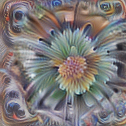
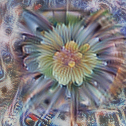
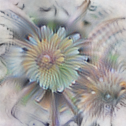
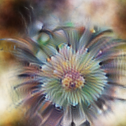
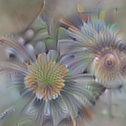
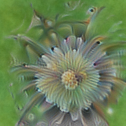
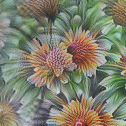
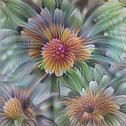


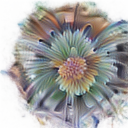
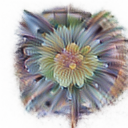
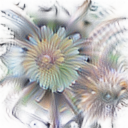
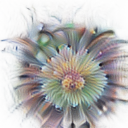
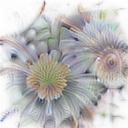
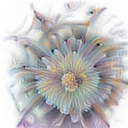
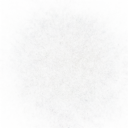
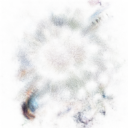


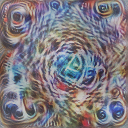
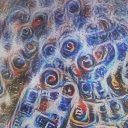
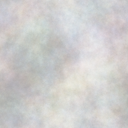
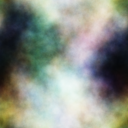
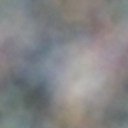
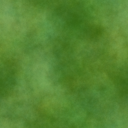
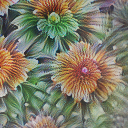
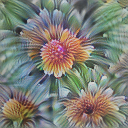


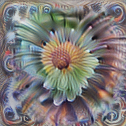
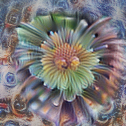
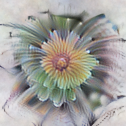
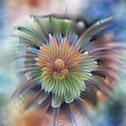
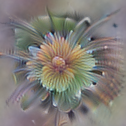
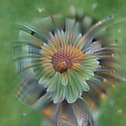
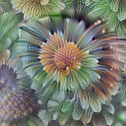
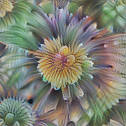


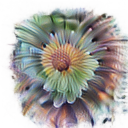
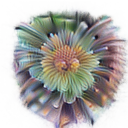
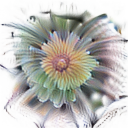
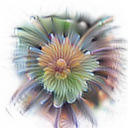
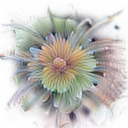
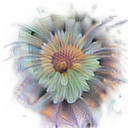
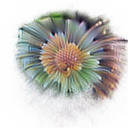
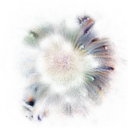


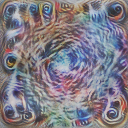
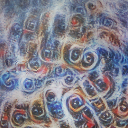
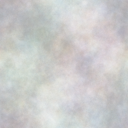
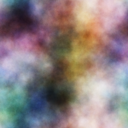
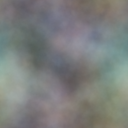
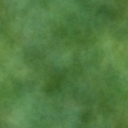
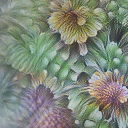
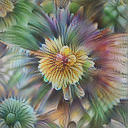


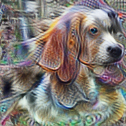
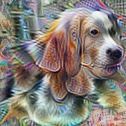
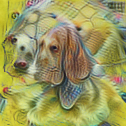
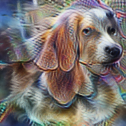
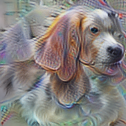
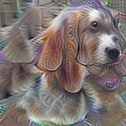
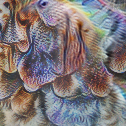
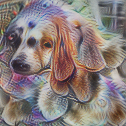


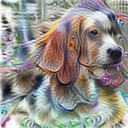
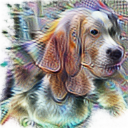
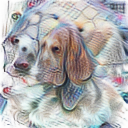
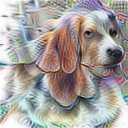
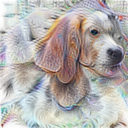
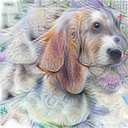
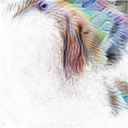
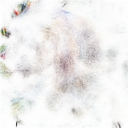


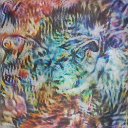
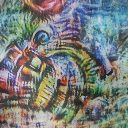
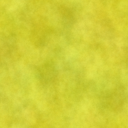
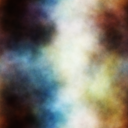
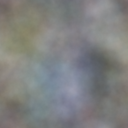
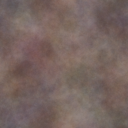
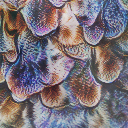
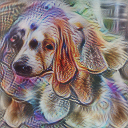

In [0]:
bg_list = [
      (True,  make_bg_func(noise_ratio=0.0, decay_power=1.5, base_sd=0.3, decorrelate=True, var_mode="image", var_image_jitter=2)),
      (True,  make_bg_func(noise_ratio=0.0, decay_power=1.5, base_sd=0.3, decorrelate=True, var_mode="image", var_image_jitter=128)),
      (True,  make_bg_func(noise_ratio=0.0, decay_power=1.5, base_sd=0.3, decorrelate=True, var_mode="color")),
      (True,  make_bg_func(noise_ratio=1.0, decay_power=2, base_sd=0.4, decorrelate=True)),
      (True,  make_bg_func(noise_ratio=1.0, decay_power=2, base_sd=0.1, decorrelate=True)),
      (False, make_bg_func(noise_ratio=0.0, decay_power=1.5, base_sd=0.3, decorrelate=True, var_mode="color")),
      (False, make_bg_func(noise_ratio=0.0, decay_power=1.5, base_sd=0.3, decorrelate=True, var_mode="image", var_image_jitter=128)),
      (False, make_bg_func(noise_ratio=0.0, decay_power=1.5, base_sd=0.3, decorrelate=True, var_mode="image", var_image_jitter=2)),
  ]

def bg_list_func(w):
  return [item[1](w)[0] for item in bg_list]

adv_list = [item[0] for item in bg_list]

  
alpha_experiment_2("mixed4b_pool_reduce_pre_relu", 16,  bg_list_func, bgs_adv=adv_list, jitter_n=2, shared_param_coef=0.0)
alpha_experiment_2("mixed4b_pool_reduce_pre_relu", 16,  bg_list_func, bgs_adv=adv_list, jitter_n=2, shared_param_coef=0.5)

alpha_experiment_2("mixed4d_pre_relu", 426,   bg_list_func, bgs_adv=adv_list, jitter_n=2)


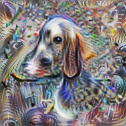
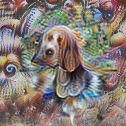
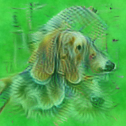
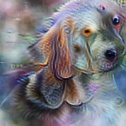
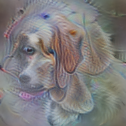
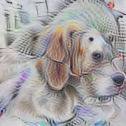
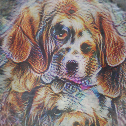
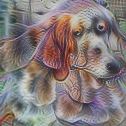


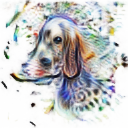
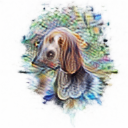
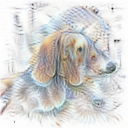
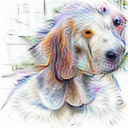
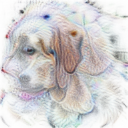
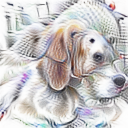
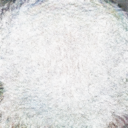
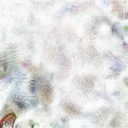


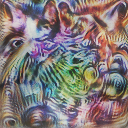
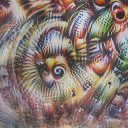
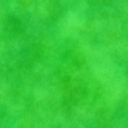
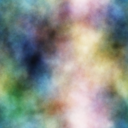
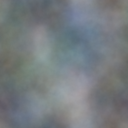
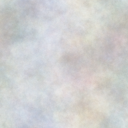
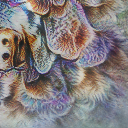
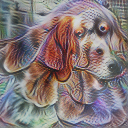

In [0]:
alpha_experiment_2("mixed4d_pre_relu", 426,   bg_list_func, bgs_adv=adv_list, jitter_n=2, shared_param_coef=0)


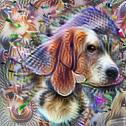
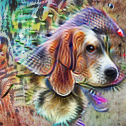
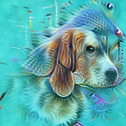
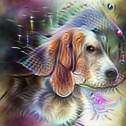
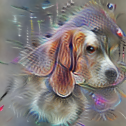
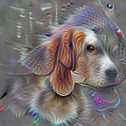
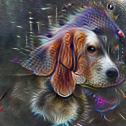
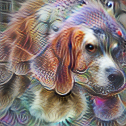


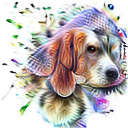
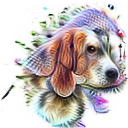
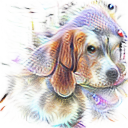
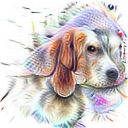
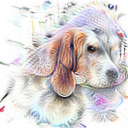
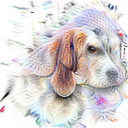
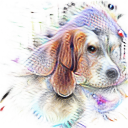
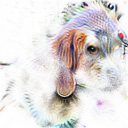


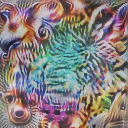
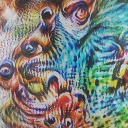
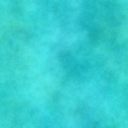
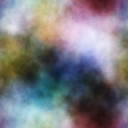
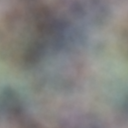
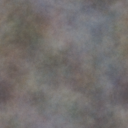
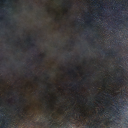
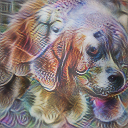

In [0]:
alpha_experiment_2("mixed4d_pre_relu", 426,   bg_list_func, bgs_adv=adv_list, jitter_n=2, shared_param_coef=1)